In [5]:
import xarray
import xarray as xr
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import numpy as np
from plot_common import annotate_skill, autoextend_colorbar, corners, get_map_norm
import xesmf
import subprocess
import glob
from typing import Any, Callable, Union
import cartopy.feature as cfeature
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
import cftime
import xskillscore as xs
from sklearn.utils import resample
from multiprocessing import Pool
import useful_functions
import importlib
importlib.reload(useful_functions)

from useful_functions import get_nwa12_outfile, weighted_annual_mean, \
                             area_masked_weighted_average, plot_epu, load_ecodata, \
                             plot_coldpool, compute_gs_points, compute_gs_expts, plot_gs, \
                             plot_epu_dclim, plot_epu_chlos_dclim, plot_epu_mclim, compute_epu_daily_clim

import warnings
warnings.filterwarnings('ignore', 'Converting a CFTimeIndex')
warnings.filterwarnings('ignore')
%matplotlib inline
! module load gcp

In [54]:
VARNAME = 'MLD_003'

if VARNAME=='MLD_003':
    freq='JFM'
elif VARNAME=='chlos':
    freq='MAM'
else:
    freq='annual'
    
nboot=100
alpha=0.10
b_len=1
nmembers=5

init_strt=1965
init_end=2024

hind_start = 1965
hind_end = 2022

clim_start = 1993
clim_end = 2019

hist_strt = 1965
hist_end = 2031

In [55]:
def block_bootstrap(var_obs, var_mod, b_len, nboot, alpha):
    ntim = var_mod.time.shape[0]
    nblocks = int(ntim / b_len)
    minin = int(nboot * alpha / 2)
    maxin = int(nboot * (1 - alpha / 2))
    medin = int(nboot * 0.5)
    corr_boot = np.empty(nboot)
    for j in range(nboot):
        if b_len == 1:
            iwo = np.random.choice(ntim, size=ntim, replace=True)
            var_obs_boot = var_obs[iwo]
            var_mod_boot = var_mod[iwo]
        else:
            iwo = np.random.choice(nblocks, size=nblocks, replace=True)
            var_obs_boot = np.empty(ntim)
            var_mod_boot = np.empty((ntim, nmembers))
            for i in range(iwo.size):     
                start = i * b_len
                end = start + b_len
                var_obs_boot[start:end] = var_obs[iwo[i] * b_len:iwo[i] * b_len + b_len]
                var_mod_boot[start:end,:] = var_mod[iwo[i] * b_len:iwo[i] * b_len + b_len,:]
            if end < ntim:
                var_obs_boot[end:] = var_obs[end:]
                var_mod_boot[end:,:] = var_mod[end:,:]                
        corr_boot[j] = np.corrcoef(var_obs_boot, np.mean(var_mod_boot,axis=1))[0, 1]
    cor_boot = np.sort(corr_boot)
    return (cor_boot[minin], cor_boot[maxin], cor_boot[medin], corr_boot)

def plot_correlation_hind_spear_ly(obs, nwa12_hind, spear_hind, init_strt, init_end, b_len, nboot, alpha):
    # Define the epu labels and number of leads
    label = ['a','b','c','d','e']
    
    epu = ['MAB_EPU', 'GOM_EPU', 'SS_EPU', 'GB_EPU', 'NEUS_LME', 'SS_LME']
    epu_values = [4, 5, 0, 1, 2, 3]

    nleads = len(nwa12_hind.lead)
    
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(3, 2)
    gs.update(hspace=0.5, wspace=0.4)

    # Create a list to store the axes for the subplots
    axs = []

    # Add the first subplot in the center of the first row
    axs.append(fig.add_subplot(gs[0, 0:2]))

    # Adjust the position of the first subplot to be centered
    axs[0].set_position([0.33, 0.68, 0.32, 0.20])
    
    # Add the remaining subplots in the second and third rows
    for i in range(1, 3):
        for j in range(2):
            axs.append(fig.add_subplot(gs[i, j]))

    # Loop through each epu value
    idx = 0
    for i in tqdm(range(len(epu))):
        if epu[epu_values[i]] == 'SS_LME':  # Skip 'SS_LME'
            continue
        ax = axs[idx]
        ax.text(-0.2,1.1,label[idx],fontweight='bold',fontsize=14,transform=ax.transAxes)
        idx += 1

        # Initialize lists to store the correlations for each lead time
        nwa12_hind_corr = []
        spear_hind_corr = []
            
        persistence_corr = []
        
        nwa12_hind_corr_min_list = []
        nwa12_hind_corr_max_list = []
        spear_hind_corr_min_list = []
        spear_hind_corr_max_list = []

        # Loop through each lead time
        for j, lead in enumerate(nwa12_hind.lead.values):
            # Assign new time coordinates for the current lead year
            start_year = init_strt + lead - 1
            end_year = init_end + lead - 1
            nwa12_hind['time'] = pd.date_range(f'{start_year}-01-01', f'{end_year}-01-01', freq='YS')
            #common_time_range = slice(max(nwa12_hind.time.min(), obs.time.min()), min(nwa12_hind.time.max(), obs.time.max()))
            common_time_range = nwa12_hind.time.values[nwa12_hind.time.isin(obs.time)]
            # Select the common time range and current lead time for both datasets
            nwa12_hind_common = nwa12_hind.sel(time=common_time_range, lead=lead)
            obs_common = obs.sel(time=common_time_range)

            # Calculate the correlation between hindcast and observations for the current lead time
            nwa12_hindcast_corr = xs.pearson_r(nwa12_hind_common.sel(epu=epu_values[i]).mean('member'), obs_common.sel(epu=epu_values[i]), dim='time')
            nwa12_hind_corr.append(nwa12_hindcast_corr.item())

            spear_hind['time'] = pd.date_range(f'{start_year}-01-01', f'{end_year}-01-01', freq='YS')
            #common_time_range = slice(max(spear_hind.time.min(), obs.time.min()), min(spear_hind.time.max(), obs.time.max()))
            common_time_range = spear_hind.time.values[spear_hind.time.isin(obs.time)]

            spear_hind_common = spear_hind.sel(time=common_time_range, lead=lead)
            obs_common = obs.sel(time=common_time_range)

            spear_hindcast_corr = xs.pearson_r(spear_hind_common.sel(epu=epu_values[i]).mean('member'), obs_common.sel(epu=epu_values[i]), dim='time')
            spear_hind_corr.append(spear_hindcast_corr.item())
            
            # Calculate the persistence correlation for the current lead time
            persistence_corr.append(pd.Series(obs.sel(epu=epu_values[i])).corr(pd.Series(obs.sel(epu=epu_values[i])).shift(periods=lead)))
            
            nwa12_hind_corr_min, nwa12_hind_corr_max, nwa12_hind_corr_med, nwa12_hind_corr_boot = block_bootstrap(
                                obs_common.sel(epu=epu_values[i]), 
                                nwa12_hind_common.sel(epu=epu_values[i]), 
                                b_len, 
                                nboot, 
                                alpha
            )
            
            nwa12_hind_corr_min_list.append(nwa12_hind_corr_min)
            nwa12_hind_corr_max_list.append(nwa12_hind_corr_max)
            
            spear_hind_corr_min, spear_hind_corr_max, spear_hind_corr_med, spear_hind_corr_boot = block_bootstrap(
                                obs_common.sel(epu=epu_values[i]), 
                                spear_hind_common.sel(epu=epu_values[i]), 
                                b_len, 
                                nboot, 
                                alpha
            )
            
            spear_hind_corr_min_list.append(spear_hind_corr_min)
            spear_hind_corr_max_list.append(spear_hind_corr_max)
        
        # Plot the correlations as a function of lead
        ax.errorbar(
            np.arange(1,11,1), 
            nwa12_hind_corr, 
            yerr=[np.abs(np.array(nwa12_hind_corr) - np.array(nwa12_hind_corr_min_list)), np.abs(np.array(nwa12_hind_corr_max_list) - np.array(nwa12_hind_corr))],
            fmt='o', capsize=5, c= '#fe6100',
            label='MOM6_NWA12_HIND vs OISST')
        
        ax.errorbar(
            np.arange(1,11,1), 
            spear_hind_corr, 
            yerr=[np.abs(np.array(spear_hind_corr) - np.array(spear_hind_corr_min_list)), np.abs(np.array(spear_hind_corr_max_list) - np.array(spear_hind_corr))],
            fmt='s', capsize=5, c= '#648fff',
            label='SPEAR_LO_HIND vs ASSIM')
        
        ax.plot(nwa12_hind.lead.values, persistence_corr, label='Persistence', c = 'k')

        # Set the title and labels
        ax.set_title(f'{epu[epu_values[i]]}')
        ax.set_xlabel('Lead')
        ax.set_ylabel('Correlation')
        ax.set_yticks(np.linspace(-0.5,1,11))
        ax.set_xticks(np.arange(1,11,1))
        ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'])
        
        if  i == 0:
            ax.legend(loc='lower left', frameon=False, fontsize='xx-small', labelspacing=1.2)
        
    # Show the plot
    plt.show()
    
def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return (da - fit).to_dataset(name='tob')

In [56]:
nwa12_hind_epu_file_path = f'/work/vnk/outdata_for_analysis/post_202412/jra3q/nwa12_hind_epu_{freq}_{VARNAME}.nc'
spear_hind_epu_file_path = f'/work/vnk/outdata_for_analysis/post_202412/jra3q/spear_hind_epu_{freq}_{VARNAME}.nc'

nwa12_hind_epu=xr.open_dataset(nwa12_hind_epu_file_path)
nwa12_hind_epu['lead'] = np.arange(1,11)

spear_hind_epu=xr.open_dataset(spear_hind_epu_file_path)
spear_hind_epu['lead'] = np.arange(1,11)

nwa12_a1_epu_file_path = f'/work/vnk/outdata_for_analysis/post_202412/jra3q/nwa12_a1_epu_{freq}_{VARNAME}.nc'
nwa12_a1_epu=xr.open_dataset(nwa12_a1_epu_file_path)

spear_a1_epu_file_path = f'/work/vnk/outdata_for_analysis/post_202412/jra3q/spear_a1_epu_{freq}_{VARNAME}.nc'
spear_a1_epu=xr.open_dataset(spear_a1_epu_file_path)

In [57]:
nwa12_hind_epu

<xarray.Dataset> Size: 73kB
Dimensions:  (epu: 6, lead: 10, time: 60, member: 5)
Coordinates:
  * member   (member) int64 40B 1 2 3 4 5
  * time     (time) datetime64[ns] 480B 1965-01-01 1966-01-01 ... 2024-01-01
  * lead     (lead) int64 80B 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: epu
Data variables:
    MLD_003  (epu, lead, time, member) float32 72kB ...

In [58]:
spear_hind_epu

<xarray.Dataset> Size: 73kB
Dimensions:  (epu: 6, lead: 10, time: 60, member: 5)
Coordinates:
  * member   (member) int64 40B 1 2 3 4 5
  * time     (time) datetime64[ns] 480B 1965-01-01 1966-01-01 ... 2024-01-01
  * lead     (lead) int64 80B 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: epu
Data variables:
    MLD_003  (epu, lead, time, member) float32 72kB ...

In [59]:
nwa12_a1_epu

<xarray.Dataset> Size: 6kB
Dimensions:  (epu: 6, time: 59, member: 4)
Coordinates:
  * time     (time) datetime64[ns] 472B 1965-01-01 1966-01-01 ... 2023-01-01
Dimensions without coordinates: epu, member
Data variables:
    MLD_003  (epu, time, member) float32 6kB ...

In [60]:
spear_a1_epu

<xarray.Dataset> Size: 8kB
Dimensions:  (epu: 6, time: 59, member: 5)
Coordinates:
  * time     (time) datetime64[ns] 472B 1965-01-01 1966-01-01 ... 2023-01-01
Dimensions without coordinates: epu, member
Data variables:
    MLD_003  (epu, time, member) float32 7kB ...

100%|██████████| 6/6 [00:25<00:00,  4.21s/it]


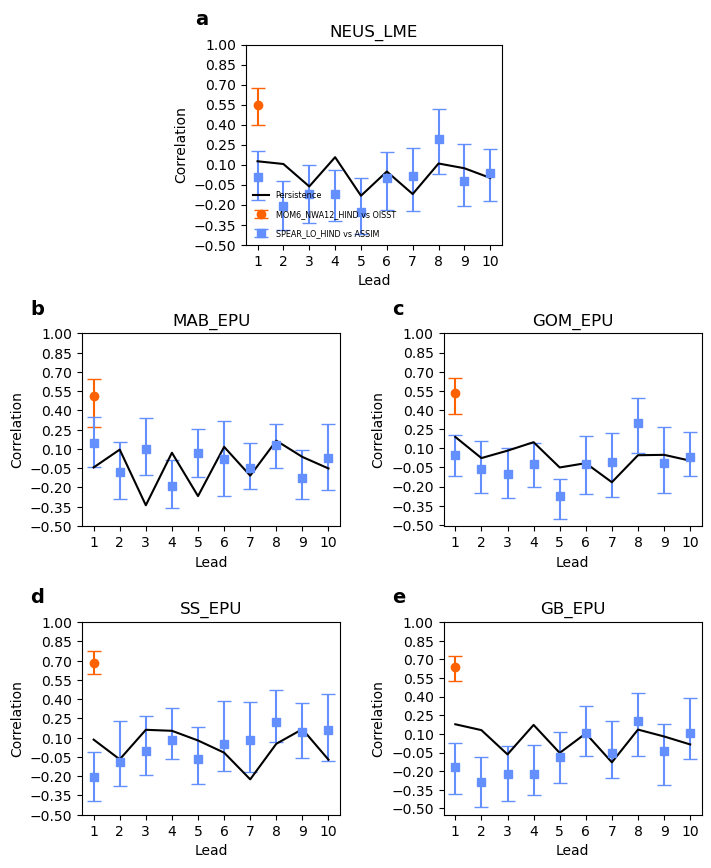

In [61]:
plot_correlation_hind_spear_ly(
    nwa12_a1_epu[VARNAME].mean(dim='member').copy(), 
    nwa12_hind_epu[VARNAME].copy(),
    spear_hind_epu[VARNAME].copy(),
    init_strt,
    init_end,
    b_len, 
    nboot, 
    alpha
)